In [1]:
import math

class Value:
    #Self is roughly eqivalant to this, 
    #__init__ is the constructor
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # Stores how we are going to chain the outputs gradients into the inputs gradients
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

        
    #repr is the toString override
    def __repr__(self):
    #Is this constructing a new object every time?
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        #To allow us to write expressions such as Value(1.0) + 1 the below expression is added. Without the next line the evaluation adds an int to a Value object
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
       # We don't want to call the function, we just want to store it so we're not calling _backward(). Calling the function returns nun
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            #self.grad = self.data * other.data This is what I put initially. Is this the same as below?
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data **(other - 1)) * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

    def __rmul__(self, other):
        return self * other
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other): #self / other
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        
        out = Value(t, (self, ), label='tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

In [2]:
#Unit Test For addition and commutativity
a = Value(2.0)
print("Addition:", a + 1)
print("Commutativity of addition:", 1+a)
#Unit test for multiplcation
a = Value(2.0)
print("Multiplication:", a * 1)

#Unit test for commtativity
#An expression such as a * 2 is equivalant to a.__mul__(2). This is non commutative because it implies 2.__mul__(a) 

print("Commutativity of multiplication", 2*a)

print("Exponentiation", a.exp())


#Power
a = Value(2.0)
b = Value(5.0)
print("Raising to the power of an int or float constant", (a**5.0).data == 2.0 ** 5.0)
##Division (but more powerful)
# a / b = a * (1/b) = a * (b**-1)
#x**k for some constant k, and -1 will be division
a = Value(2.0)
b = Value(4.0)

print("Division Test a / b", (a / b).data == 2.0/4.0)

Addition: Value(data=3.0)
Commutativity of addition: Value(data=3.0)
Multiplication: Value(data=2.0)
Commutativity of multiplication Value(data=4.0)
Exponentiation Value(data=7.38905609893065)
Raising to the power of an int or float constant True
Division Test a / b True


In [3]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graphviz
    nodes, edges = set(), set()
    

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
 
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) ##LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node for items
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to items
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
       #Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


NameError: name 'L' is not defined

In [ ]:
L = d * f
#dL/dc
#dd/dc = e
#d = c + e



#WANT: dL/dc = (dL / dd) * (dd / dc)
#
# KNOW: 
# dL / dd
# dd / dc
#

In [5]:

lol()

NameError: name 'lol' is not defined

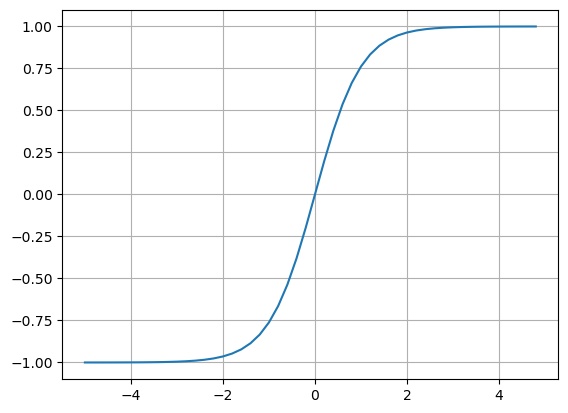

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid();

In [7]:
#This section defines the data

#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
#bias of the neuron 
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w1'

n = x1w1x2w2 + b; n.label ='n'

o = n.tanh(); o.label = 'o'


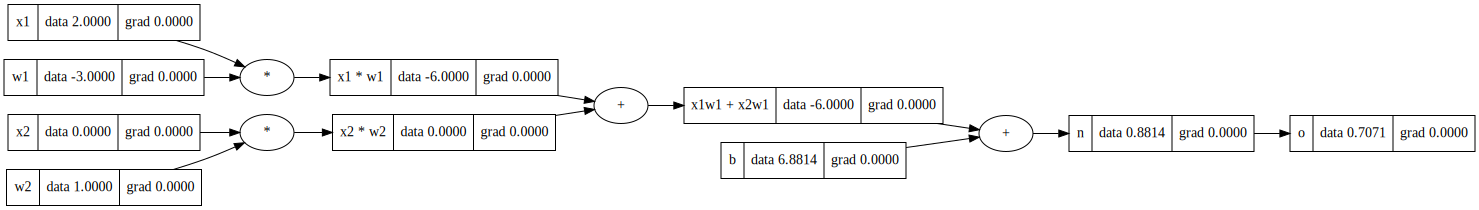

In [8]:
#Draws the graph Before Backpropagation. Note that the grads are all zero.
draw_dot(o)

In [9]:
oldstuff = """x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1w1.grad = 0.5
x2w2.grad = 0.5

x1w1x2w2.grad = 0.5

b.grad = 0.5
o.grad = 1.00
n.grad = 0.5"""

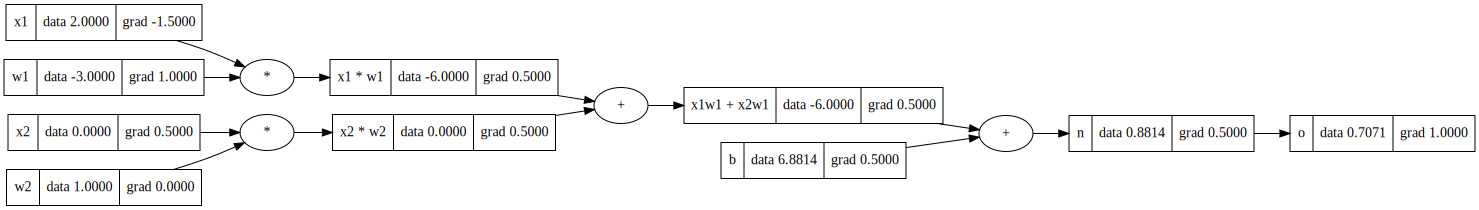

In [10]:
#Backpropagation for One neuron
o.backward()
draw_dot(o)

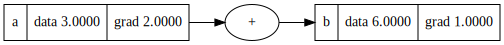

In [11]:
#Fixing a bug - below is the scenario
a = Value(3.0, label='a')
b = a + a ; b .label = 'b'
b.backward()
draw_dot(b)

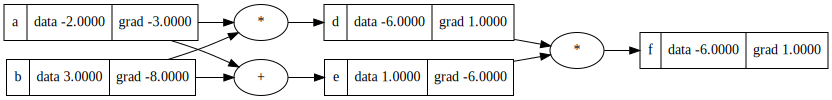

In [12]:
#The derivative of b with respect to a returns 1 + 1
a =  Value(-2.0, label='a')
b =  Value(3.0, label='b')
d = a * b ; d.label = 'd'

e = a + b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()
draw_dot(f)